# Lab 7 | Dimension Reduction and Tree-Based Methods

In this lab, we cover the following topics:

- Dimension Reduction
    - Principal Component Analysis
    - Principal Component Regression
    - Partial Least Squares
- Decision Trees

### Overview

Assume the data contains `p` predictors, however, not all of them are useful. Hence, dimension reduction attempts to improve out-of-sample fit by reducing the complexity to avoid overfitting.

As you already know, there are several methods to achieve this goal:

 - **Subset Selection:** Get rid of some predictors by selecting a feature combination with lowest error 
    - FSS, BSS, and _SequentialFeatureSelector_
 - **Shrinkage:** Reduce the influence of some predictors by reducing the magnitude of their coefficients closer to zero
    - Lasso and Ridge Regression
 - **Dimension Reduction:** Create new predictors that are combinations of original ones, which helps reduce multicollinearity between predictors
    - PCA/PCR and Partial Least Squares (today's material)


### Dimension Reduction

We already saw the two first ones so today we will learn the third - Dimension Reduction. The genral idea here is to reduce dimensionality in datasets with a large number of predictors by constructing latent variables. Latent variables are created through the linear combination of the original predictors. This is especially necessary if there is high multicollinearity between the original predictors - the latent variables get constructed as a new set of uncorrelated features that can be used to make predictions on the y variable. The goal of these techniques is to maximize the variance between the predictors. 


### Linear Alegra Behind Dimension Reduction

**Note:** do not feel overwhelmed by these mathematical models and terms. You are not expected to know or memorize these formulas, we just wanted to provide the infromation for those who would like a deeper understanding.

The idea behind dimension reduction is to create new predictors by projecting the original `p` predictors into a new space (`M` < `p`). There are two steps to dimension reduction:

1. Define the projection

> Let $ Z = (Z_{1}, ..., Z_{M}) $ represent `M` < `p` combinations of the original `p` predictors:
> $$ Z_{m} = \sum_{j=1}^{p}\phi_{j}^{m}X_{j} $$
> for loadings $ \phi^{m} = (\phi_{1}^{m}, ..., \phi_{p}^{m}) $
> The new predictors (`Z`) are linear combinations of original predictors (X).
>
> ![DimensionReductionSteps](DimensionReductionSteps.png)

2. Estimate the new OLS model

> Given the new vector of `M` < `p` different Zs, we estimate a new OLS model:
> $$ Y = \theta_{0} + \sum_{m=1}^{M}\theta_{m}Z_{m} + \nu $$

Interestingly, $ \beta_{j} = \sum_{m=1}^{M}\theta_{m}\phi_{j}^{m} $ where $ \beta_{j} $ is the original OLS estimator.

When we talk about dimension reducion, the underlying goal is really to determine estimates for the loadings ($ \phi $). 


###  Two Methods of Dimension Reduction

 - **Principal Components Analysis (PCA):** Unsupervised (only considers input variables during performance)
 - **Partial Least Squares (PLS):** Supervised (considers relationship between input _and_ output variables during performance)

###  1. Principal Components Analysis (PCA) and Principal Components Regression (PCR)
- Benefits:
     - reduces dimensionality of the data (i.e. fewer number of features)
     - eliminates multicollinearity and redundant information
     - enhances predictive performance by focusing on the most important relationships in the data
- Drawbacks:
     - interpretability can be challenging since the outcome features are not the orignial variables from the dataset (rather, the outcome features are linear combinations of the original variables)
     - may not perform well if the relationship between the original predictor variables and the y variable is highly nonlinear
     - assumes latent variables with the largest variance are the most important for predicting y, which is not always the case

#### Principal Component Analysis

PCA is the process of finding `M` latent features (i.e. principal components) to use in the model.

The algorithm goes as follows:

 1. The first principal component is the (normalized) linear combination of the predictors with the largest variance:   
    $ max_{{\hat{\phi}}^{1}} \underbrace{\frac{1}{n} \sum_{i=1}^{n} ( \overbrace{\sum_{j=1}^{p} \phi_{j}^{1} x_{ij}}^{z_{1}} )^{2}}_{var(z_{1})} $ subject to $ \sum_{j=1}^{p} (\phi_{j}^{1})^{2} = 1 $.

 2. The second principle component is the (normalized) linear combination of predictors with the largest variance subject to being uncorrelated with the first principle component.

 3. Repeat step 2 until we have `M` principal components.

Within the iterative process of PCA we will use cross-validation to find `M` - the number of principal compenents, aka latent variables.

#### Principal Component Regression

Principal Component Regression (PCR) is the entire pipeline of first finding the principal components through PCA and then running an OLS regression on them.  

Said differently, PCR is the entire process of performing PCA + fitting the regression model and obtaining predictions on the y target variable. We select the optimal `M` number of principal component features based on the lowest test MSE.

#### Let's see an example of applying PCA and PCR on a dataset called `bike`.

We will attempt to predict the number of bikes rented using various features relating to the date and weather.

In [1]:
# Data packages
import numpy as np
import pandas as pd

# Sci-kit learn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Load the bike dataset
bike = pd.read_csv('bike.csv')
bike.drop(['dteday'], axis=1, inplace=True)
display(bike.head())
display(bike.shape)

# Separate X and y
X = bike.drop(['cnt'], axis = 1)
y = bike['cnt']

# Do a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(17379, 16)

Once we split our dataset, the steps for PCR are as follows:  
1. Scale the data  (Transformation 1)
     - Scaling is extremely important! Otherwise variables with the largest values will be seen as the most important, which is not the case. Similarly, unscaled data naturally increases the variance between features; this will disrupt the performance of PCA, which selects principle components based on features with the highest variance.
2. Perform PCA on `m` number of features (Transformation 2)
      - Since PCA is an unsupervised method, we don't need to use the target y variable to find the latent features.
      - sklearn does all the work for us to find principal components with the `PCA` method.
3. Fit linear regression model on the `m` number of principle component features

These steps can be established in a pipeline. Pipelines are used to standardize the dimension reduction process so our results will be consistent every time. 

![Pipelines](Pipelines.png)

Below, we will iterate through the entire X_train dataset; at each iteration, perform the pipeline and save the corresponding training error for the given `m` number of principle conponent features at that step.

In [3]:
# scale the data
scalar = StandardScaler() 
scalar.fit(X_train)
X_train_scaled = scalar.transform(X_train) 
X_test_scaled = scalar.transform(X_test)

In [4]:
# Storing the MSEs
train_error = {}

# Perform PCR for all possible number of principal components
for m in range(1, len(X_train.columns)+1):
    pcr = make_pipeline(
        StandardScaler(), # First Transformer - scale the data
        PCA(n_components=m), # Second Transformer - PCA to find M number of principal components
        LinearRegression()
    ).fit(X_train, y_train)

    train_error[m] = np.mean(-1 *cross_val_score(pcr, X_train_scaled,
                    y_train, cv=KFold(n_splits=10,
                random_state=1,
                shuffle=True), scoring='neg_mean_squared_error'))


Text(0.5, 1.0, 'Principal Component Regression')

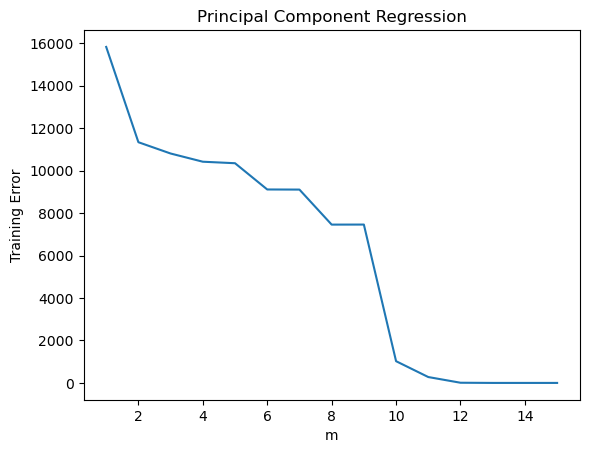

In [5]:
# Visualize the results:
# graph train_error by m number of principle component features

plt.figure(facecolor='white')
plt.plot(list(train_error.keys()), list(train_error.values()))
plt.xlabel('m')
plt.ylabel('Training Error')
plt.title('Principal Component Regression')

#### From the graph, how do we determine the optimal number of principal components? 

The answer - it depends on the data! (surprise surprise) 

There are two approaches:
1. **select `M` where error is minimized**: there are certain instances where this method will be necessary, however, most of the time the minimum error will occur where `M` is equal to the max number of principle components. Choosing this value would contradict our goal of dimension reduction, so it might not always be the best option. 
2. **the elbow technique**: select the `M` where there was just a big drop in accuracy, however there isn't too large of an improvement in accuracy afterwards. This would mean that the principal components that improve the accuracy a lot are included while those with only marginal benefits (i.e. those that add noise) are not. 

Here is a tradeoff between these two methods found on pg 259 of the textbook: 
- "The relatively worse performance of PCR is a consequence of the fact that the data were generated in a way such that many principal components are required in order to adequately model the response."  
     - this is where minimization might be favored
- "In contrast, PCR will tend to do well in cases when the first few principal components are sufficient to capture most of the variation in the predictors as well as the relationship with the response."  
     - this is where elbow method might be favored

In this lab, we will go in favor of the elbow technique. We can see that this "elbow" occurs when m=10. This is our sweet spot! Now, we can fit a model using PCR when m=10, and evaluate our test error. 

In [6]:
pcr = make_pipeline(PCA(n_components=10), LinearRegression())
# Fit the PCR pipeline on the training data
pcr.fit(X_train_scaled, y_train)
# Assess the fit using the test data
y_predict = pcr.predict(X_test_scaled)
#obtain the test error
test_mse = mean_squared_error(y_test, y_predict)
print("Test MSE for PCR: ", test_mse)

Test MSE for PCR:  1033.396529015951


### Partial Least Squares

Like Principal Component Regression, Partial Least Squares (PLS) is a dimension reduction method. However, it is a supervised method because it uses the outcome, Y, when computing the latent features.

The Partial Least Squares algorithm goes as follows:

1. Standardize the `p` predictors
2. For each predictor `j`, fit the Linear Regression on X and Y train  
3. Compute the first direction $ z_{i1} = \hat{\phi}_{1}^{1}x_{i1} + ... + \hat{\phi}_{p}^{1}x_{ip} $ by setting each $ \hat{\phi}_{j}^{1} = \hat{\beta}_{j}\ \forall\ j $
4. For each predictor j, predict the residuals, $ \hat{u}_{ij} $, from a simple linear regression of $ X_{j} $ on $ Z_{1} $: $ x_{ij} = \hat{\alpha}_{0} + \hat{\alpha}_{j}z_{i1} + \hat{u}_{ij}\ \forall\ j $
5. Replace $ X_{j} $ with $ \hat{u}_{ij} $ and repeat steps 2-5

Don't worry too much about the math here because these steps are taken care of for you by the _PLSRegression_ package in sklearn. 


Repeat an iterative process for each value of `m` using PLS!

Text(0.5, 1.0, 'Partial Least Squares')

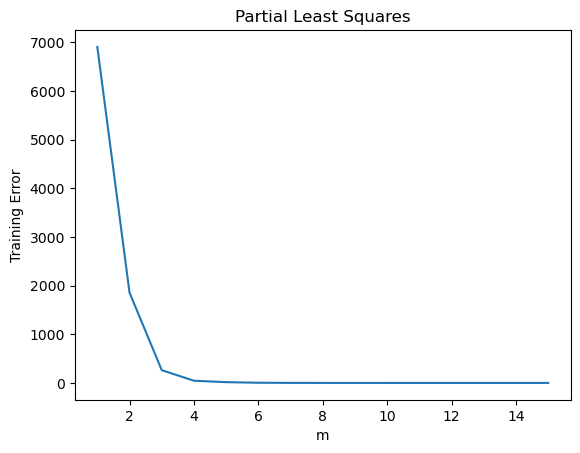

In [9]:
# Storing the MSEs
train_error2 = {}

# Perform PCR for all possible number of principal components
for m in range(1, len(X_train.columns)+1):
    pls = PLSRegression(
        n_components=m,
        scale=True
    ).fit(X_train, y_train)
    
    train_error2[m] = np.mean(-1*cross_val_score(pls, X_train_scaled,
                    y_train, cv=KFold(n_splits=10,
                    random_state=1,
                    shuffle=True), scoring='neg_mean_squared_error'))

# Visualize the results
plt.figure(facecolor='white')
plt.plot(list(train_error2.keys()), list(train_error2.values()))
plt.xlabel('m')
plt.ylabel('Training Error')
plt.title('Partial Least Squares')

It looks like either 2 or 3 components are optimal according to the elbow-technique!

In [10]:
# fit and predict a regression model using three transformed features
pls = PLSRegression(
        n_components=3,
        scale=True
    ).fit(X_train, y_train)

y_predict = pls.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_predict)
print("Test MSE for PLS: ", test_mse)


Test MSE for PLS:  93418.39567875247


c:\Users\RichardCampo\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


### Decision Trees

Decision trees are beloved by many because they are quite intuitive and easily interpretable.

The hierarchical structure of a decision tree leads us to the final outcome by traversing through the nodes of the tree. Each node consists of an attribute or feature which is further split into more nodes as we move down the tree.

It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves).

Essentially, once the tree is built, it is really easy to make predictions. However, building the tree turns out to be a lot more difficult. It is so difficult and complex that we spend over 100 slides on them in the lectures! For brevity, we won't go over the details here, but give you a brief summary of the most important building blocks to develop the necessary intuition.

In essence, tree divide a space, but finding the optimal way to divide it is too costly in terms of computations (there is a nearly infinite way of dividing even just a 2D space up). Thus, we will use recursive binary splitting:

- **Recursive:** Treats every branch recursively so the algorithm goes down a branch until it finds a leaf before rolling back and going down the next branch.
- **Binary:** Each node will have two children (expect if it is a leaf, then 0)
- **Splitting:** Well, we do split, don't we?

Below, the numbered red arrows illustrate how the tree gets built using recursion. Notice that each internal node has exactly two children because of the binary aspect.

![RecursiveBinarySplitting](RecursiveBinarySplitting.png)

Formally, the algorithm goes as follows:

1. Select the best predictor `j` and cutpoint `s` such that we split the predictor space into two regions, $ R_{1}(j, s) = {X|X_{j} < s}\ and\ R_{2}(j, s) = {X|X_{j} >= s} $, that lead to the largest decrease in RSS.
2. Select the next best predictor `j` and cutpoint `s` so that it further splits an existing region into two regions, $ R_{1}(j, s)\ and\ R_{2}(j, s) $, that lead to the largest decrease in RSS.
    - Almost repeats the previous step but instead of splitting the entire predictor space but instead of splitting the entire predictor space, it splits one of the existing regions.
3. Repeat step 2 until a stopping criterion is reached

Now we know almost everything but how to define the best split at a given node. For this, we use splitting measures like Gini Index, Information Gain, etc.

The Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen. Formally: $ G = \sum_{k=1}^K \hat{p}_{lk}(1-\hat{p}_{lk}) $

Hence, $ G \in [0, 1] $ where 0 indicates that all observations in a node are from the same class and 1 indicates perfect impurity (i.e., 50% of observations are from each of the two possibles classes).

The recursive binary splitting algorithm will use the Gini index to determine which predictor `j` and cutpoint `s` to use by looking which combination offers be lowest Gini score in the resulting children.

Alright, now that we have a theoretical understanding of decision trees, let's look into how they work in practice.

Using the wine dataset from last week's lab, we will attempt to determine the quality score of red wine based on its characteristics. 

In [11]:
wine = pd.read_csv("winequality-red.csv", sep=";")
wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


We want to make our outcome variable binary, so we will create a new column for the target called "quality_binary" where "quality_binary" = 0 if "quality" = 3, 4, or 5 (low quality), and "quality_binary" = 1 if "quality" = 6, 7, or 8 (high quality).

In [12]:
wine["quality_binary"]  = 0
wine.loc[wine.loc[:, "quality"] >=6, "quality_binary"] = 1
display(wine.head())
display(wine.describe())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_binary
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023,0.534709
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.000000


Of course, since we are performing classification, we need to know our baseline. This is the frequency of the most common class or, in other words, the percentage of correct predictions we would get if we were to always predict the most frequent class.

In [13]:
# Split into X and y
X = wine.drop(['quality', 'quality_binary'], axis = 1)
y = wine['quality_binary']

# Baseline accuracy
print(y.value_counts())
print(f'\nBaseline Accuracy: {y.value_counts().values.max()/len(y)}')

1    855
0    744
Name: quality_binary, dtype: int64

Baseline Accuracy: 0.5347091932457786


Alright, it looks like we'll need to get a better accuracy than 53%. Let's see what we can do.

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state = 1)

Before trying to play around with the various parameters, let's understand how the algorithm decides which splits to do. We saw that the algorithm will recursively choose the predictor and cutoff that reduce the (training) RSS the most.

Let's use 2 features in this simple example so that we can visualize the predictor space.

c:\Users\RichardCampo\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\RichardCampo\AppData\Local\Temp\ipykernel_15412\1263084204.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(
c:\Users\RichardCampo\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\RichardCampo\AppData\Local\Temp\ipykernel_15412\1263084204.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(
c:\Users\RichardCampo\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\RichardCampo\AppData\Local\Temp\ipykerne

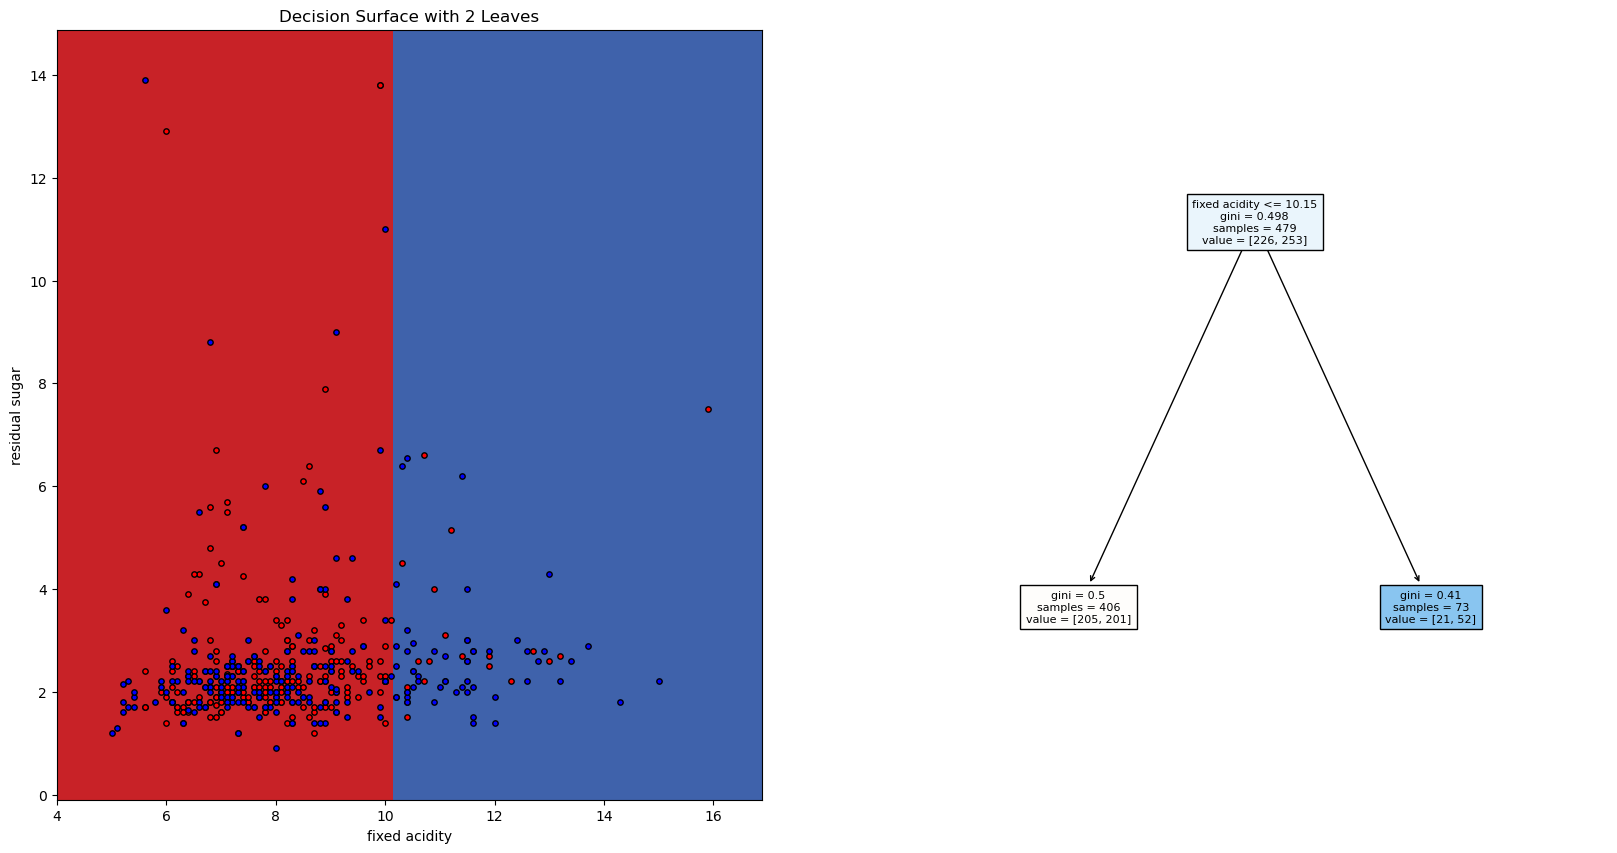

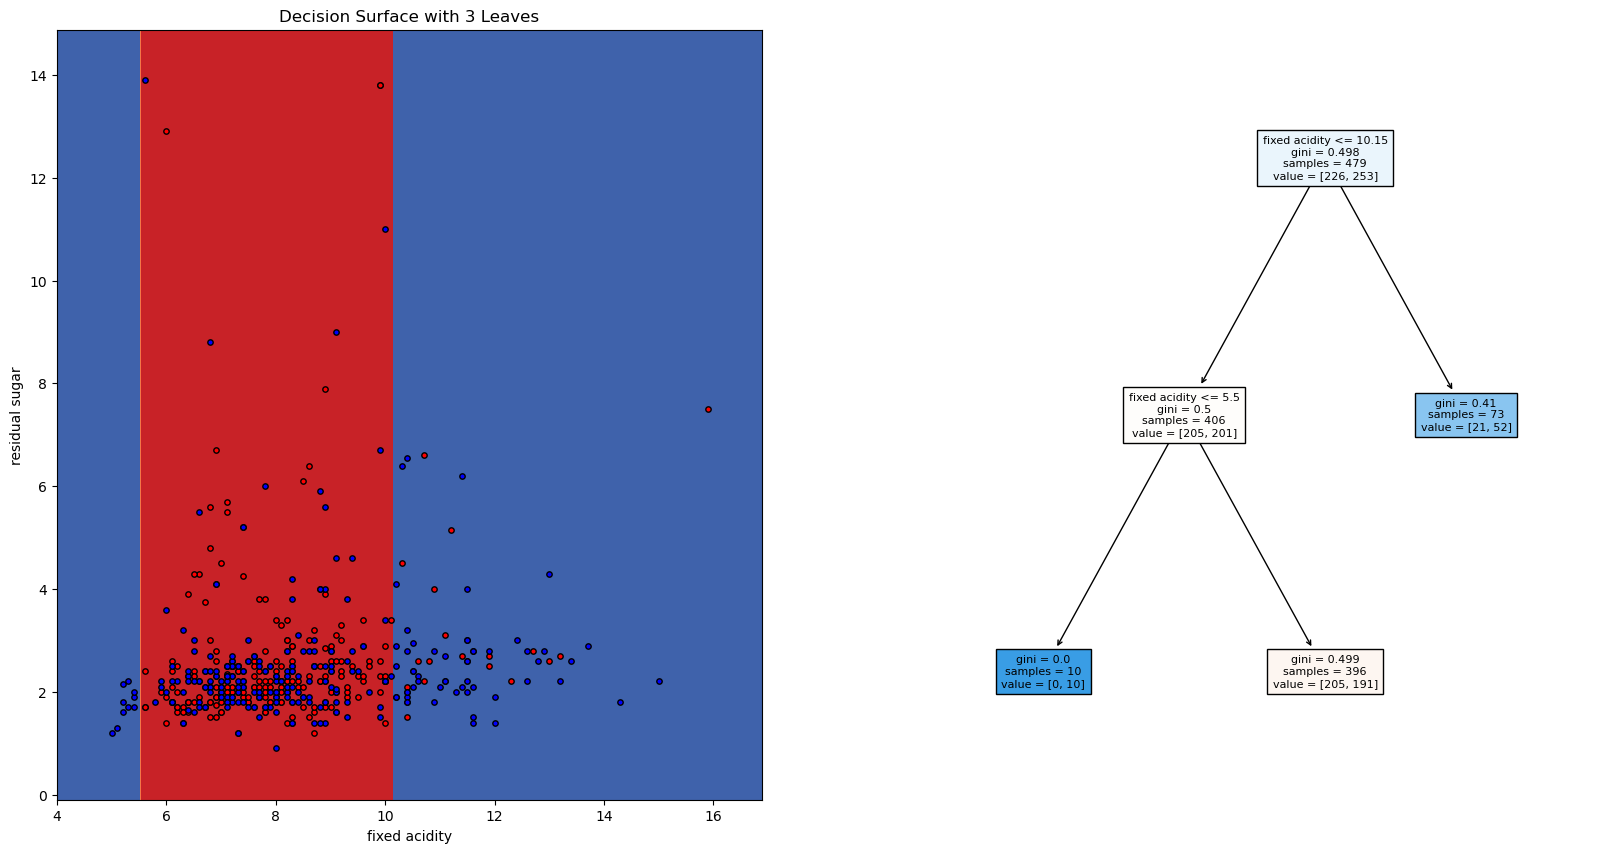

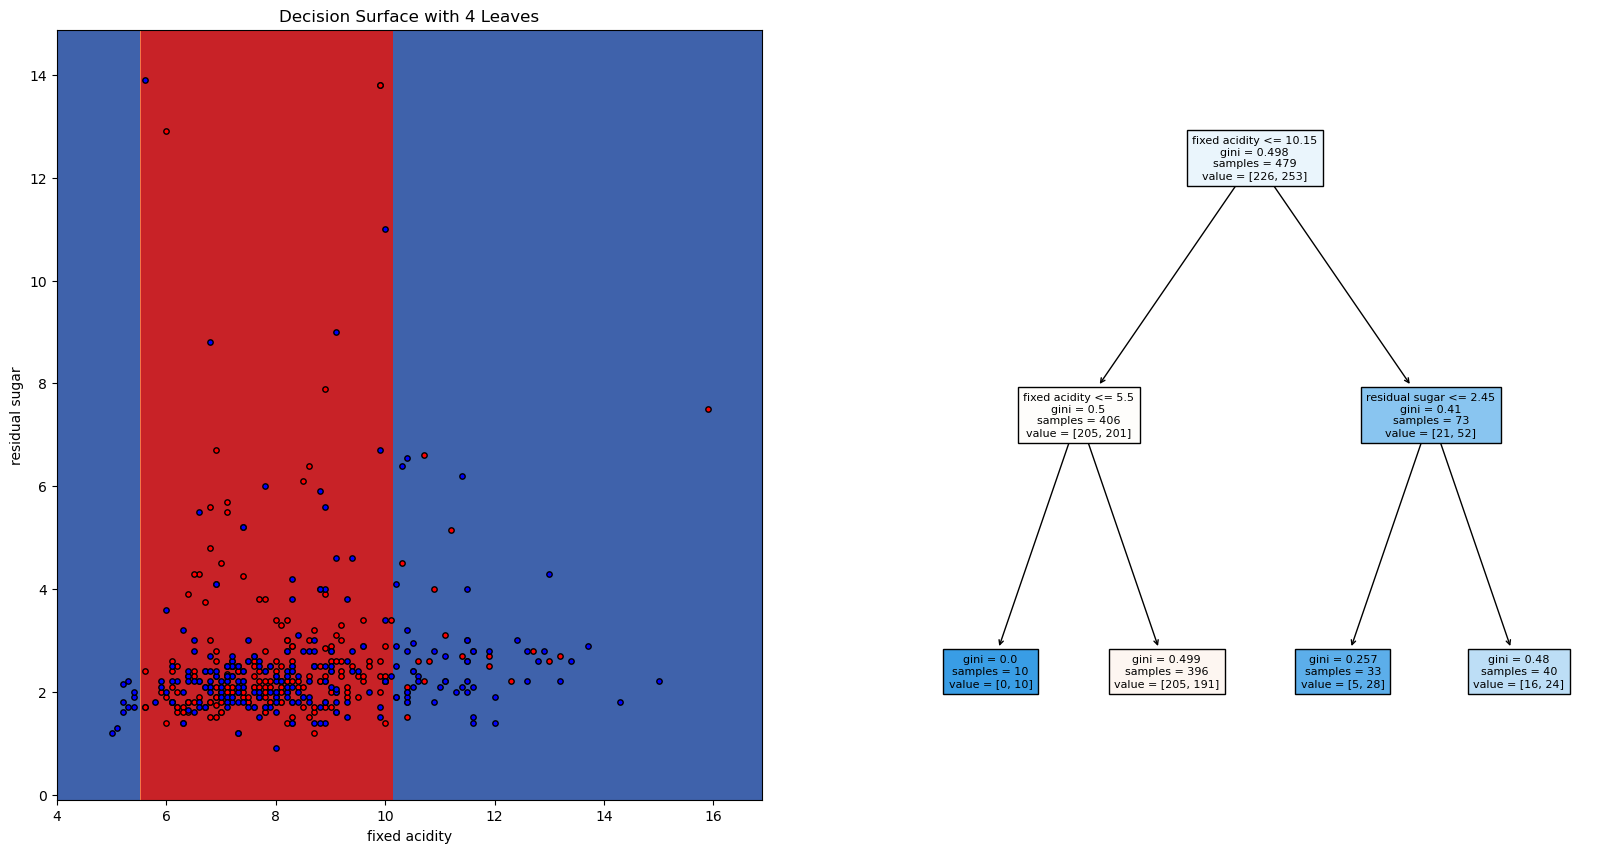

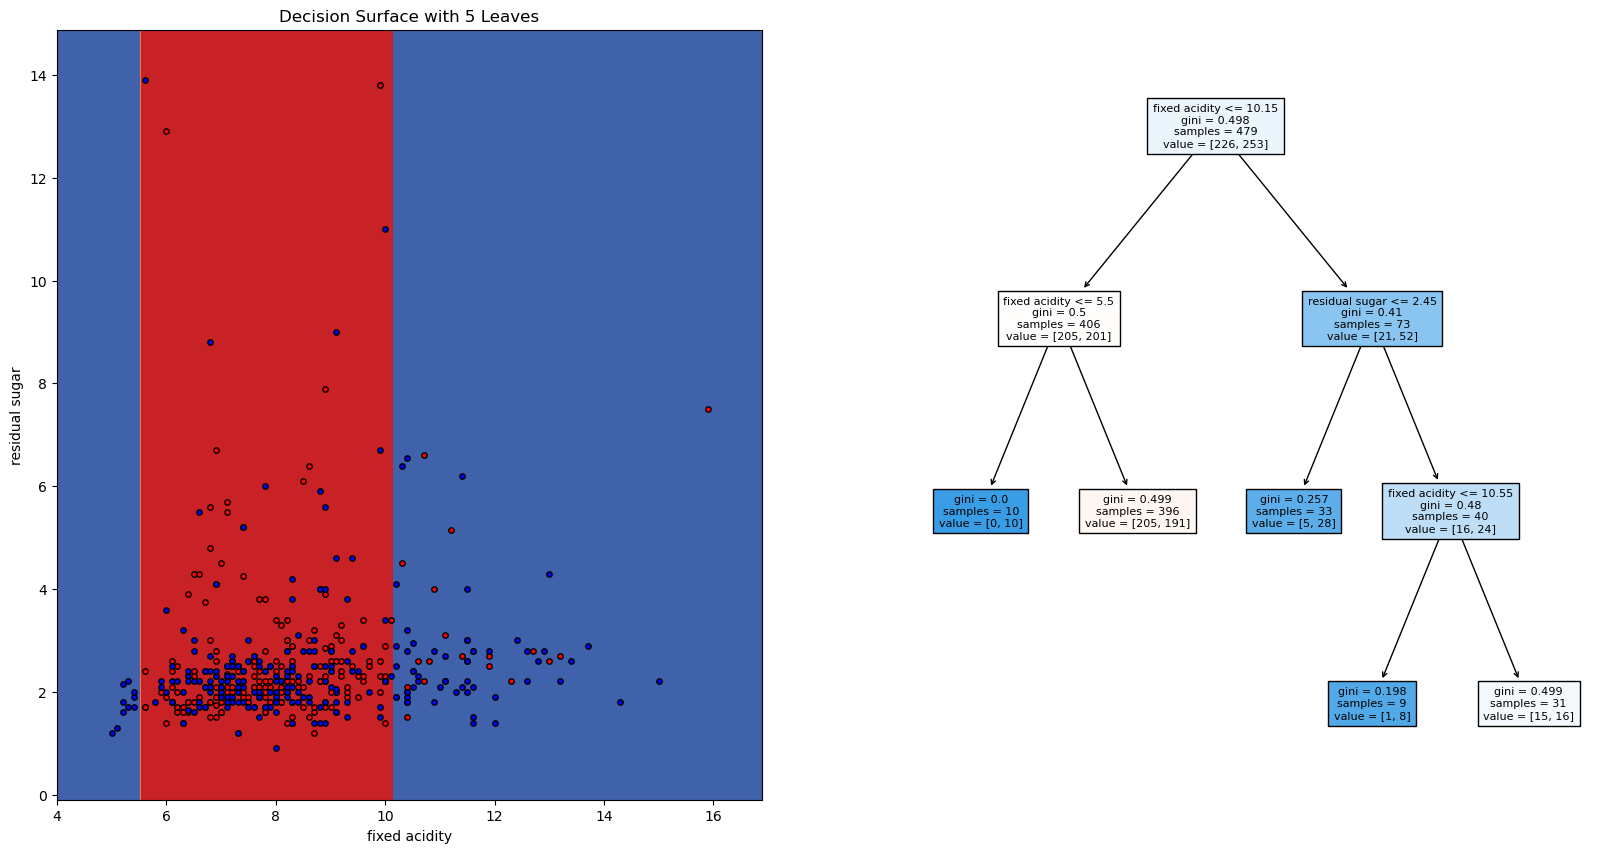

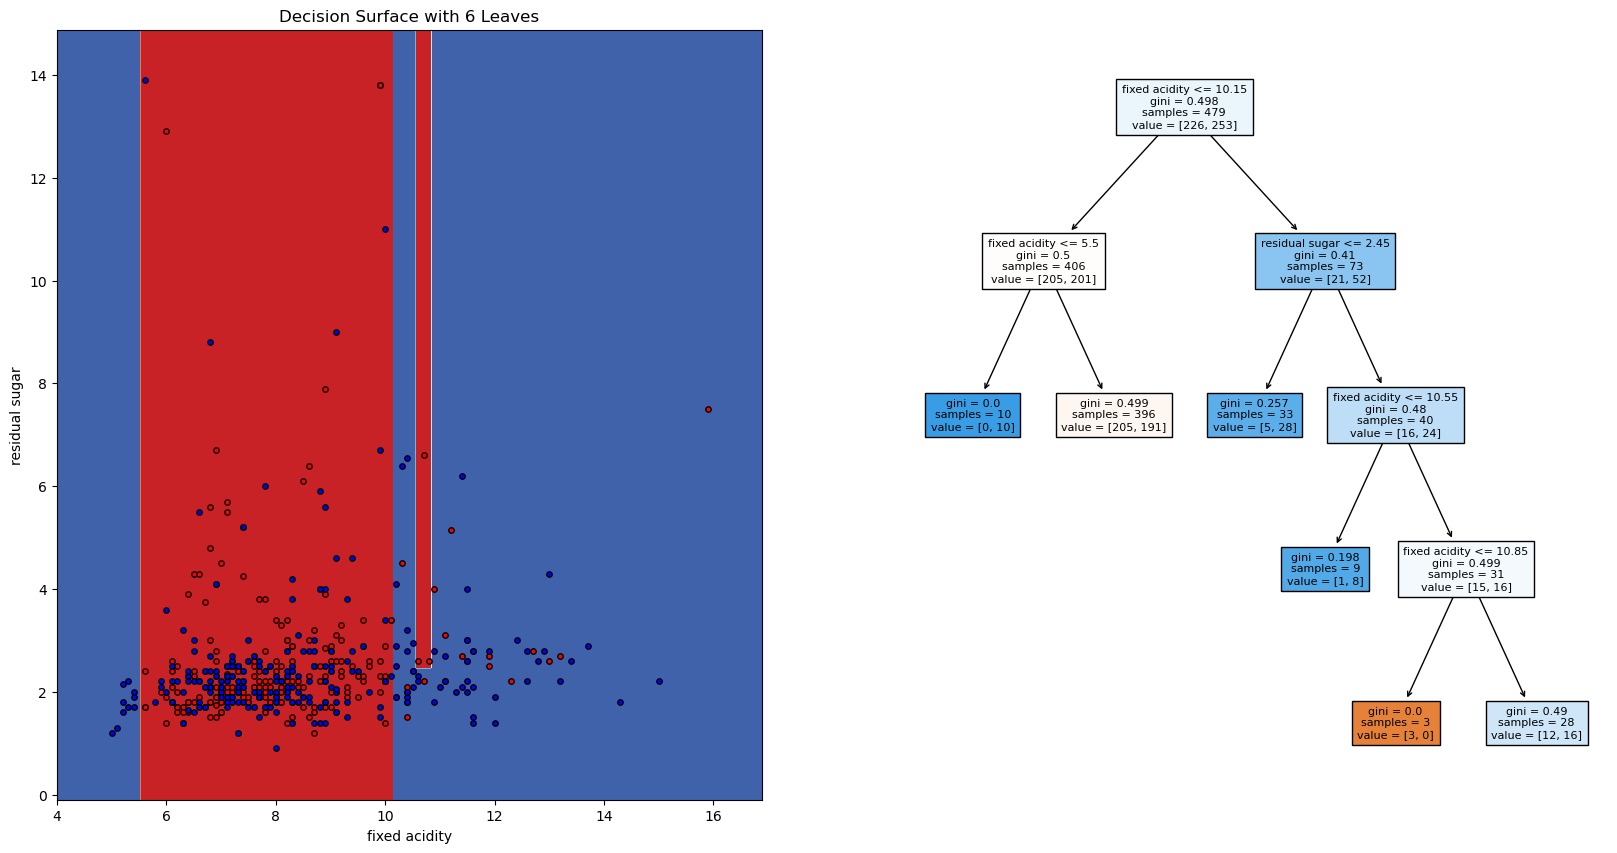

In [15]:
# Use only 2 features
features_2D = [
    'fixed acidity',
    'residual sugar'
]

X_train_2D = X_train[features_2D]

# Make the tree iteratively larger
for max_leaves in range(2, 7):
    
    # Fit the model with an increasing maximum depth
    model = DecisionTreeClassifier(
        max_leaf_nodes=max_leaves,
        random_state=1,
        criterion='gini'
    ).fit(X_train_2D, y_train)

    # Compute the decision areas
    plot_step = 0.02
    x1_min, x1_max = X_train_2D.iloc[:, 0].min() - 1, X_train_2D.iloc[:, 0].max() + 1
    x2_min, x2_max = X_train_2D.iloc[:, 1].min() - 1, X_train_2D.iloc[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, plot_step),
        np.arange(x2_min, x2_max, plot_step)
    )
    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    # Plot the decision areas
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].contourf(xx1, xx2, Z, cmap=plt.cm.RdYlBu)

    # Plot the training observations
    for i, color in zip(range(2), 'rb'):
        idx = np.where(y_train == i)[0]
        axs[0].scatter(
            X_train_2D.iloc[idx, 0],
            X_train_2D.iloc[idx, 1],
            c=color,
            cmap=plt.cm.RdYlBu,
            edgecolor='black',
            s=15
        )
    
    # Plot the tree
    axs[1] = tree.plot_tree(
        model,
        fontsize=8,
        feature_names=features_2D,
        filled=True
    )

    # Plot aestetics
    axs[0].set(
        title=f'Decision Surface with {max_leaves} Leaves',
        xlabel=features_2D[0],
        ylabel=features_2D[1]
    )

As one can see, it is quite easy to spot where the splits happen and how the decision area rapidly becomes more complex.

As we build the tree further down (i.e. increase our number of leaves), the number of splits increases gradually. Note that sometimes a split is made that does not seem to have any impact because it still predicts the same class for both children. However, it still decreases the impurity and give the opportunity to further split the subspaces and refine the predictions.


### Pruning Decision Trees
It is important to note that without restrictions, decision trees will often overfit the training data. In other words, they will continue to create splits on increasingly irrelevant features as they become more vulnerable to noise in the training data. Just like in linear regression, we need to hypertune our parameters (AKA "pruning" in the context of Decision Trees).  

There are different parameters we can choose to control in order prevent overfitting and reduce noise in the model:  
1. Tree depth
    - `max_depth`: Maximum depth of the tree
    - `min_samples_leaf`: Minimum number of samples that must be in a leaf
    - `max_leaf_nodes`: Maximum number of leaf nodes
2. Impurity limits/ Stopping criteria
    - `min_impurity_decrease`: Only split a node if it decreases its impurity by at least a minimum amount
3. Complexity Cost
    - `cost_complexity_pruning_path` / `ccp_alpha`: adds a cost parameter such that more complex trees are penalized. 
4. etc.

Let's see this in practice. 

Start by fitting a full, unpruned decision tree.

Training Accuracy: 1.0
Test Accuracy: 0.6785714285714286


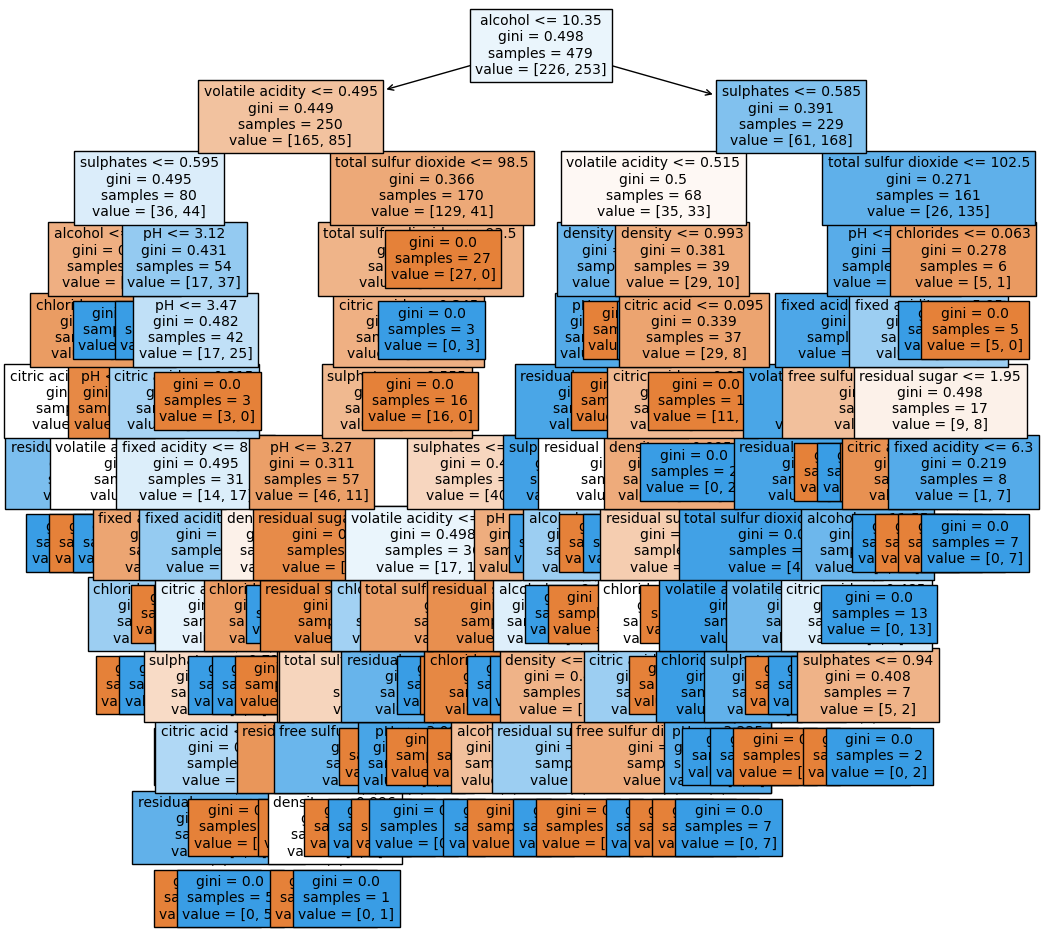

In [16]:
# No stopping criterion
full_model = DecisionTreeClassifier(
    random_state=12,
    criterion='gini')
full_model.fit(X_train, y_train)

print(f'Training Accuracy: {full_model.score(X_train, y_train)}')
print(f'Test Accuracy: {full_model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(full_model, fontsize=10, feature_names=X_train.columns.tolist(), filled=True)
plt.show()

Fit the full, unpruned tree on the test data to see it's predictive ability.

Test Error Rate: 0.3214285714285714


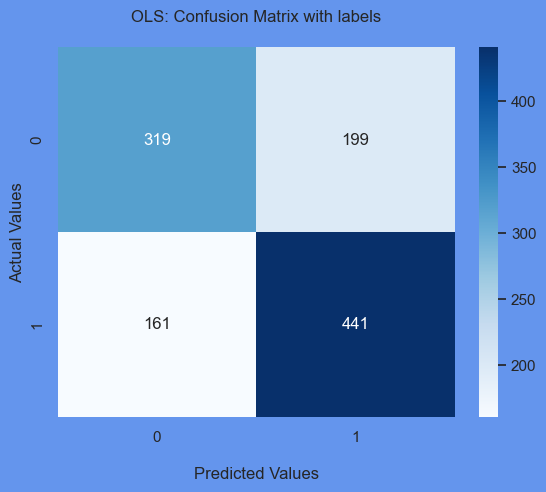

In [17]:
y_hat_test = full_model.predict(X_test)
cm = confusion_matrix(y_test, y_hat_test)

sns.set(rc={'figure.facecolor': 'cornflowerblue'})
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
ax.set_title('OLS: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')
print("Test Error Rate:", 1-accuracy_score(y_test, y_hat_test))

On this full, unpruned tree, we can see that the training accuracy is 1. Obviously, we are facing major overfitting!

Now, let's see what these stopping criteria can do for us. First, let's specify the maximum depth as it is the most intuitive. Essentially, we tell the tree that it is not allowed to go beyond a certain depth, no matter what.

Training Accuracy: 0.7849686847599165
Test Accuracy: 0.7196428571428571


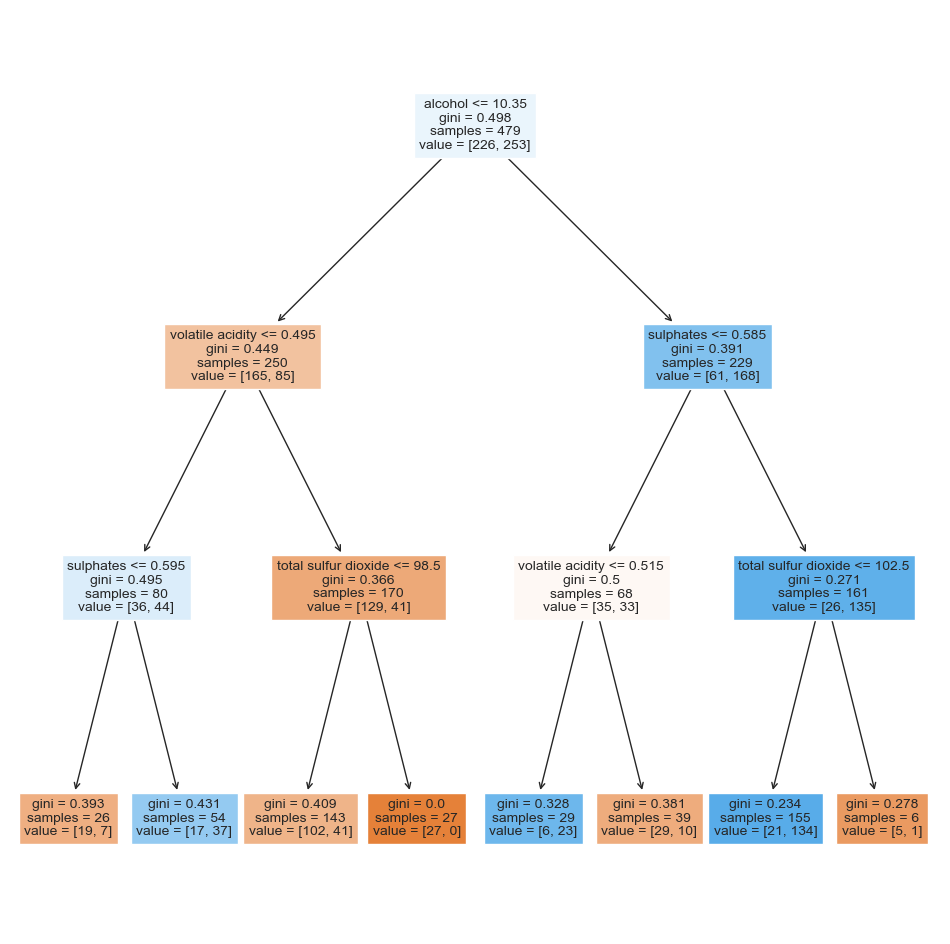

In [18]:
# Maximum depth
max_depth_model = DecisionTreeClassifier(
    max_depth=3,
    random_state=1,
    criterion='gini').fit(X_train, y_train)

print(f'Training Accuracy: {max_depth_model.score(X_train, y_train)}')
print(f'Test Accuracy: {max_depth_model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(max_depth_model, fontsize=10, feature_names=X_train.columns.tolist(), filled=True)
plt.show()

Already much better! The test accuracy has improved greatly compared to the full unpruned tree. Our training error has decreased which indicates that the model is prevented from overfitting to the training data as bedly as before.

Notice how the tree is perfectly symmetric. This is typical when using `max_depth` as the stopping criterion is the only reason a branch would not reach the maximum depth - if an ('internal') node is perfectly homogeneous.

Another popular stopping criterion is called `min_impurity_decrease`. It determines by how much the score used to compute the purity of a node (e.g., Gini) needs to decrease to allow a split to happen.

Training Accuracy: 0.7515657620041754
Test Accuracy: 0.6839285714285714


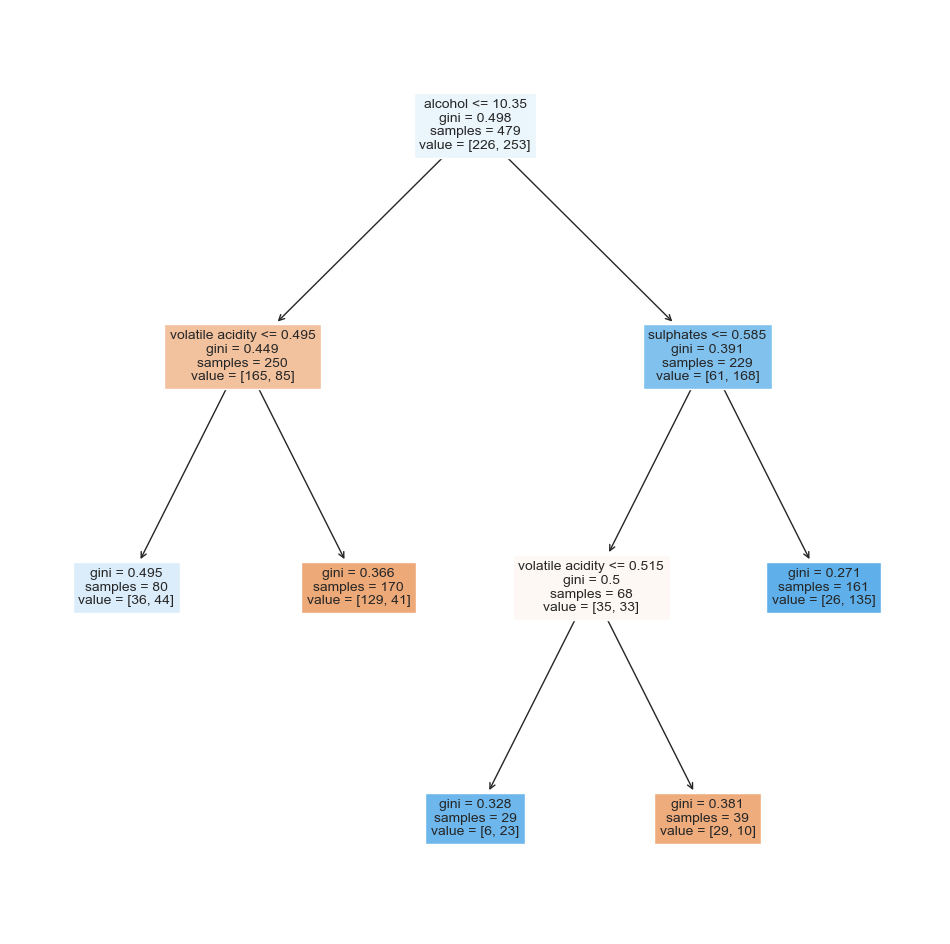

In [19]:
# Minimum decrease in impurity
model = DecisionTreeClassifier(
    min_impurity_decrease=0.02,
    random_state=1,
    criterion='gini').fit(X_train, y_train)

print(f'Training Accuracy: {model.score(X_train, y_train)}')
print(f'Test Accuracy: {model.score(X_test, y_test)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(model, fontsize=10, feature_names=X_train.columns.tolist(), filled=True)
plt.show()

Finally, the last stopping criterion we will cover is cost complexity pruning, where we will hypertune a parameter called `ccp_alpha`.

`ccp_alpha` is a complexity parameter that penalizes more complex trees. To tune ccp_alpha, you experiment with different values of ccp_alpha until you find the optimal balance between tree complexity and generalizability. 

Let's experiment with finding an optimal value of `ccp_alpha` for our wine dataset.

In [20]:
# use the .cost_complexity_pruning_path() function to fit various values of α to the training data
path = full_model.cost_complexity_pruning_path(X_train, y_train)
# get list of ccp_alpha values created for experimentation
ccp_alphas = path.ccp_alphas
#  save these values in a dictionary
parameters = {'ccp_alpha': ccp_alphas}

# Use GridSearchCV to iterate over the CCP alphas... 
kf = KFold(n_splits=5, random_state = 13, shuffle=True)
cv_tree = GridSearchCV(full_model, parameters, cv = kf, scoring='accuracy')
cv_tree.fit(X_train, y_train)
# ... and save the corresponding CV error for each alpha level
cv_scores = []
for mean_score in cv_tree.cv_results_["mean_test_score"]:
    # create list of error rates produced by each corresponding ccp_alpha 
    # (errors are saved in the same order as their alpha values appear in the ccp_alpha list)
    cv_scores.append(1-mean_score)

And let's analyze our results:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


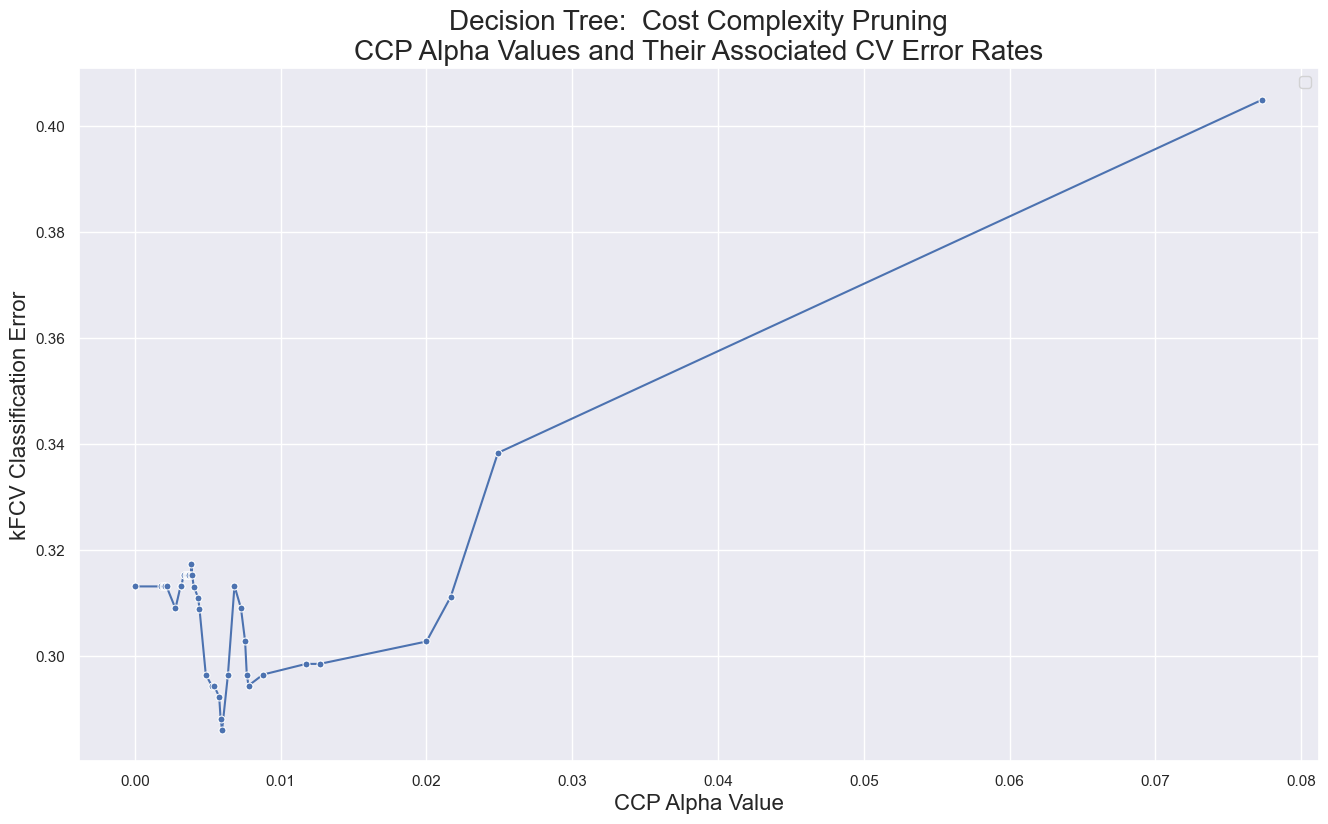

In [21]:
# Plot the error rate as a function of alpha
fig, ax = plt.subplots(figsize=(16,9), facecolor='white')
sns.lineplot(x=ccp_alphas, y=cv_scores, marker='o', markersize=5, ax=ax)
ax.set_ylabel("kFCV Classification Error", fontsize=16)
ax.set_xlabel("CCP Alpha Value", fontsize=16)
ax.set_title('Decision Tree:  Cost Complexity Pruning'
             '\nCCP Alpha Values and Their Associated CV Error Rates',
             fontsize=20)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


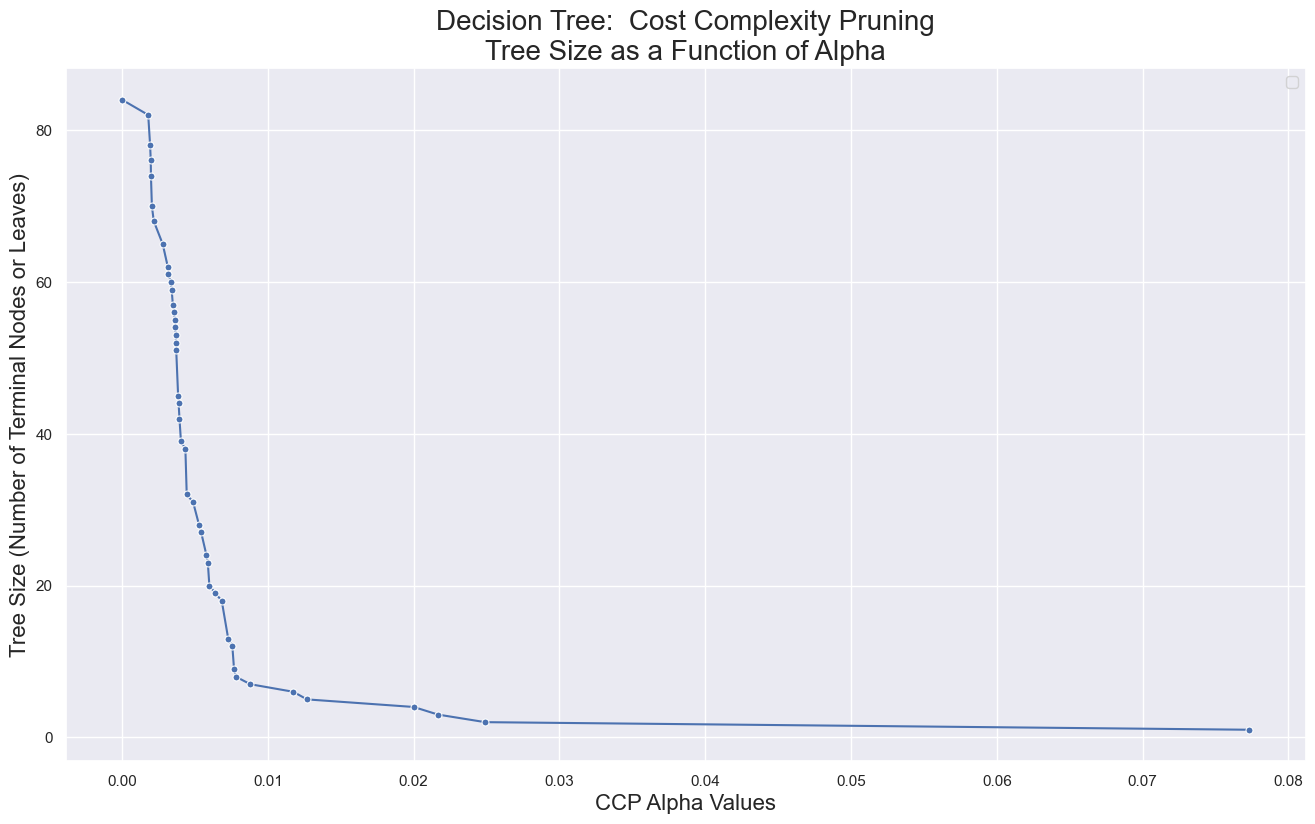

In [22]:
# Plot the tree size as a function of alpha
tree_size = []
for a in ccp_alphas:
    clf_a = DecisionTreeClassifier(ccp_alpha=a, random_state=2, criterion='gini')
    clf_a.fit(X_train, y_train)
    tree_size.append(clf_a.get_n_leaves())

fig, ax = plt.subplots(figsize=(16,9), facecolor='white')
sns.lineplot(x=ccp_alphas, y=tree_size, marker='o', markersize=5, ax=ax)
ax.set_ylabel("Tree Size (Number of Terminal Nodes or Leaves)", fontsize=16)
ax.set_xlabel("CCP Alpha Values", fontsize=16)
ax.set_title('Decision Tree:  Cost Complexity Pruning'
             '\nTree Size as a Function of Alpha',
             fontsize=20)
plt.legend()
plt.show()

Is there anything you notice from these two graphs about the relationship between CV error rates, ccp_alpha values, and tree sizes?

In [32]:
# determine the alpha value where the minimum cv error occured
min_error = min(cv_scores)
idx = np.where(cv_scores == min_error)[0][0]
alpha_at_min_error = ccp_alphas[idx]
# and get the size of the tree at this alpha value
size_at_min_error = tree_size[idx]

print(f"The lowest classification error rate is {min_error}."
      f"\nThe alpha that corresponds to this value is {alpha_at_min_error}"
      f"\nThe tree size that corresponds to this value is {size_at_min_error}")

The lowest classification error rate is 0.28603070175438594.
The alpha that corresponds to this value is 0.005983721265819762
The tree size that corresponds to this value is 20


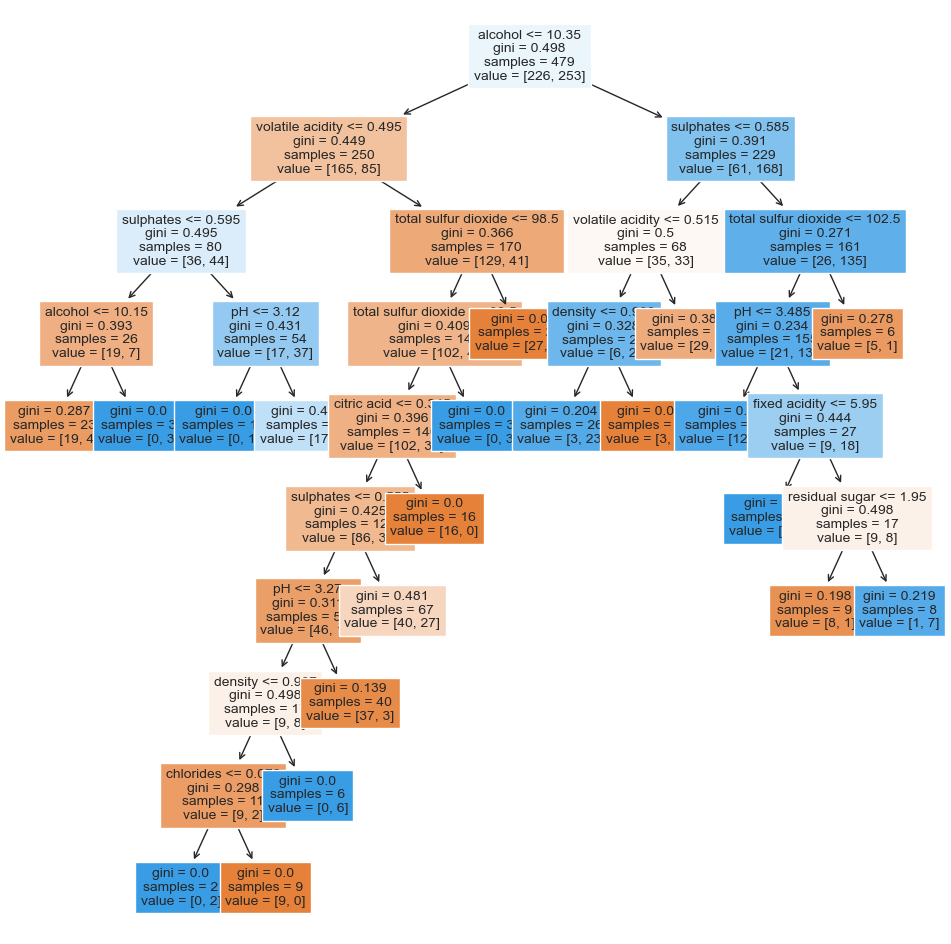

Test Error: 0.2928571428571428


DecisionTreeClassifier(ccp_alpha=0.005983721265819762, random_state=2)

In [23]:
# Fit the pruned tree using the optimal level of alpha obtained
pruned_model = DecisionTreeClassifier(ccp_alpha=0.005983721265819762, random_state=2, 
                                     criterion='gini').fit(X_train, y_train)

#show a visual display of the tree
plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(pruned_model, fontsize=10, feature_names=X_train.columns.tolist(), filled=True)
plt.show()

# make predictions on the test set using the optimal, pruned tree model
print(f'Test Error: {1 - pruned_model.score(X_test, y_test)}')

pruned_model